# Import Packages

In [1]:
import numpy as np
import scipy.integrate as integrate
import scipy.sparse as sps
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import time
import cmath
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from numpy import exp,arange
import datetime
from tqdm.auto import tqdm
%matplotlib inline

#plt.style.use('seaborn') # I personally prefer seaborn for the graph style, but you may choose whichever you want.
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

from matplotlib import rc

# render animations inline
rc('animation', html='html5')

# Loading Results From DRAC

In [ ]:
n=10000
m=100
N = 1000
N_frames = 401
t_max = 250
s = t_max/N
sides = [-5, 5, -10, 90]
frames = np.linspace(0,N,N_frames,dtype='int').tolist()
T = np.vectorize(lambda t : t*s)(frames)
x = np.linspace(sides[0],sides[1],n+2)[1:n+1]
y = np.linspace(sides[2],sides[3],m+2)[1:m+1]
sol = np.load("output/CNSResults_100x10000.npy")
hx = x[1]-x[0]
hy = y[1]-y[0]
def g(x):
    return(abs(x)**2)
    #return(x.real)
gv = np.vectorize(g)

X = np.diag(x)
X2 = np.diag(np.vectorize(lambda x : x**2)(x))
Y = np.diag(y)
Y2 = np.diag(np.vectorize(lambda x : x**2)(y))
psi = np.zeros((N+1,n,m),dtype='complex')
Z = np.zeros((N+1,m,n),dtype='float')

observables = np.zeros((N+1,3))

def F(x):
    if abs(x)>1e-14:
        return(-np.real(x)*np.log(np.real(x)))
    else:
        return(0)

st = time.time()
print("Starting...")
for i in range (0,N+1):
    gnat = sol[i]
    gnat = np.reshape(gnat,(m,n),order='C')
    Z[i,:,:] = np.flipud(gv(gnat))
    psi[i,:,:] = np.transpose(gnat)
    rho1 = hx*hy*np.matmul(psi[i,:,:],psi[i,:,:].conj().T)
    rho2 = hx*hy*np.matmul(psi[i,:,:].T,psi[i,:,:].conj())
    observables[i,0] = T[i]
    observables[i,1] = np.real(np.trace(rho1))-1
    #observables[i,2] = np.real(np.trace(np.matmul(rho1,X)))
    #observables[i,3] = (np.real(np.trace(np.matmul(rho1,X2)))-observables[i,2]**2)**(0.5)
    #observables[i,4] = np.real(np.trace(np.matmul(rho2,Y)))
    #observables[i,5] = (np.real(np.trace(np.matmul(rho2,Y2)))-observables[i,4]**2)**(0.5)
    observables[i,3] = np.sum(np.vectorize(F)(np.linalg.eig(rho1)[0]))
    elapsed = datetime.timedelta(seconds=round(time.time()-st))
    remaining = datetime.timedelta(seconds=round((time.time()-st)/(i+1)*(N-i)))
    print(round(i/N*100),'% ',elapsed,'elapsed',remaining,'remaining',end='\r')

Zmax = Z.max()

Starting...


# Error in Simulation

In [ ]:
fig_norm, ax_norm = plt.subplots()
ax_norm.plot(observables[:,0],observables[:,1])
plt.ylabel('Error in Wavefunction Normalization')
plt.xlabel('Time $t$') 

# Entropy

In [ ]:
fig_S, ax_S = plt.subplots()
ax_S.plot(observables[:,0],observables[:,6])
ax_S.set_ylabel('von Neumann entanglement entropy $S$')
ax_S.set_xlabel('Time $t$') 
plt.show()

# Movie of Time Evolution of $|\Psi|^2$

In [ ]:
def animate(frame):
    global Z, image
    image.set_array(Z[frame,:,:])
    return image,

fig, ax = plt.subplots()
image = ax.imshow(Z[0,:,:],cmap=cm.Purples,vmin=0,vmax=0.5*Zmax,extent=sides,aspect='auto');
#image = ax.imshow(Z[0,:,:],cmap=cm.plasma,norm=LogNorm(vmin=1e-10, vmax=1),extent=sol[4],aspect='auto');
bar = plt.colorbar(image)
bar.set_label('probability density $|\psi(t,x,y)|^2$') 
plt.ylabel('Projectile Coordinate') 
plt.xlabel('Oscillator Coordinate') 

ani = animation.FuncAnimation(fig,animate,np.arange(0, N-1), blit=True,interval=10000/N);

In [ ]:
ani

In [ ]:
ani.save(filename="PsiEvoLam1m400Video.mp4", writer="ffmpeg")

# 3D Surface Animation

<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
<>:14: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_9462/2330660160.py:14: SyntaxWarning: invalid escape sequence '\p'
  bar.set_label('probability density $|\psi(t,x,y)|^2$')
/tmp/ipykernel_9462/2330660160.py:17: SyntaxWarning: invalid escape sequence '\p'
  ax.set_zlabel('Psi Amplitude $|\psi(t,x,y)|^2$')


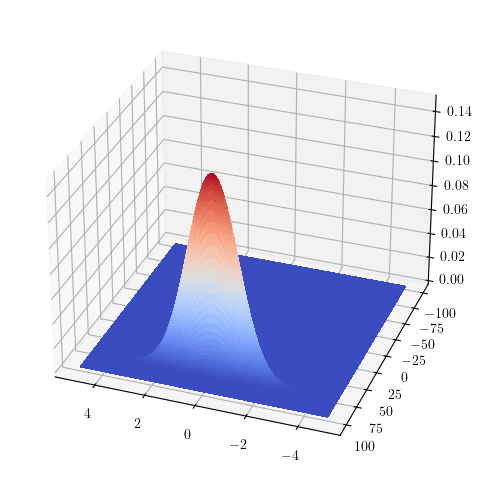

In [32]:
X,Y = np.meshgrid(x,y)
Y = np.flip(Y)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection = '3d')
ax.view_init(30,110,0)
ax.plot_surface(X,Y,Z[0,:,:], cmap = cm.coolwarm, antialiased=False, linewidth=0)

def animate3d(frame):
    ax.cla()
    ax.plot_surface(X,Y,Z[frame,:,:], rstride=1, cstride=1, cmap = cm.coolwarm, antialiased=False, linewidth=0)
    ax.set_zlim(0, 0.15)
    return fig,

bar.set_label('probability density $|\psi(t,x,y)|^2$') 
ax.set_ylabel('Projectile Coordinate') 
ax.set_xlabel('Oscillator Coordinate') 
ax.set_zlabel('Psi Amplitude $|\psi(t,x,y)|^2$')

ani = animation.FuncAnimation(fig = fig, func = animate3d, frames = np.arange(0, N-1),interval=10000/N, repeat=True);

In [33]:
ani

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '600x600', '-pix_fmt', 'rgba', '-framerate', '40.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpw7d_goaj/temp.m4v']' returned non-zero exit status 255.

In [34]:
ani.save(filename="PsiEvo_3D_X10Y100.mp4", writer="ffmpeg")

MovieWriter stderr:
[out#0/mp4 @ 0x5cc5edc0e540] Nothing was written into output file, because at least one of its streams received no packets.



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '600x600', '-pix_fmt', 'rgba', '-framerate', '40.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', 'PsiEvo_3D_X10Y100.mp4']' returned non-zero exit status 255.

# Integral: $\int |\Psi|^2 dx$

Text(47.04155697736137, 0.5, 'Integrated Wavefunction w.r.t $x$')

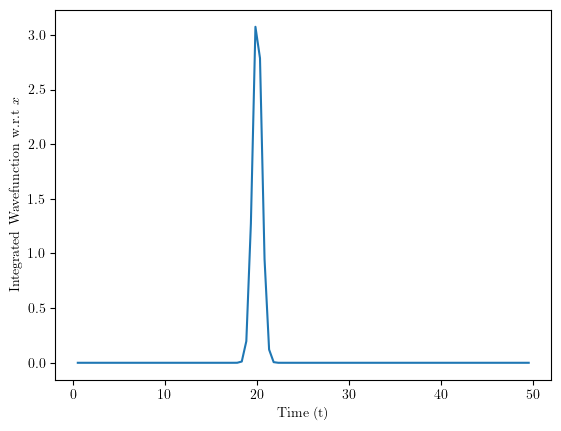

In [117]:
Zx = np.trapz(Z, x, axis=1)

fig, ax = plt.subplots()
line, = ax.plot(x, Zx[0])

num_frames = np.size(Zx, 0)
def intXAnim(frame):
    line.set_ydata(Zx[frame])
    return line,

ani = animation.FuncAnimation(fig, intXAnim, np.arange(0, N-1), blit=True, interval = 4000/num_frames)

plt.xlabel('Time (t)') 
plt.ylabel('Integrated Wavefunction w.r.t $x$') 

In [118]:
ani.save(filename="XInt.mp4", writer="ffmpeg")
ani

# Integral: $\int |\Psi|^2 dy$

Text(40.123035794589725, 0.5, 'Integrated Wavefunction w.r.t $y$')

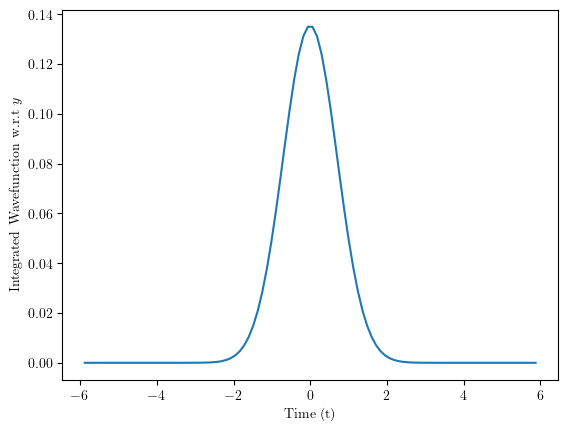

In [119]:
Zy = np.trapz(Z, y, axis=2)

fig, ax = plt.subplots()
line, = ax.plot(y, Zy[0])

num_frames = np.size(Zy, 0)
def intXAnim(frame):
    line.set_ydata(Zy[frame])
    return line,

ani = animation.FuncAnimation(fig, intXAnim, np.arange(0, N-1), blit=True, interval = 4000/num_frames)

plt.xlabel('Time (t)') 
plt.ylabel('Integrated Wavefunction w.r.t $y$') 

In [120]:
ani.save(filename="YInt.mp4", writer="ffmpeg")
ani